In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt

In [2]:
# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


In [3]:
# Configuration
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = '/content/drive/MyDrive/rps-cv-images'

In [4]:
# Check if directory exists
if not os.path.exists(DATA_DIR):
    print(f"ERROR: Directory {DATA_DIR} not found!")
    print("Please check your folder path in Google Drive")
else:
    print(f"Found dataset at: {DATA_DIR}")
    print(f"Contents: {os.listdir(DATA_DIR)}")

Found dataset at: /content/drive/MyDrive/rps-cv-images
Contents: ['scissors', 'rock', 'paper']


In [5]:
# Data augmentation for training
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    validation_split=0.2,  # 20% for validation
    fill_mode='nearest'
)


In [6]:
# Only rescaling for validation
val_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [7]:
print("\nLoading training data...")
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)


Loading training data...
Found 3014 images belonging to 3 classes.


In [8]:
print("Loading validation data...")
val_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Loading validation data...
Found 751 images belonging to 3 classes.


In [9]:
print(f"\nClasses found: {train_generator.class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")


Classes found: {'paper': 0, 'rock': 1, 'scissors': 2}
Training samples: 3014
Validation samples: 751


In [10]:
# Build the model using transfer learning with MobileNetV2
print("\nBuilding model...")
base_model = keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')  # 3 classes: rock, paper, scissors
])


Building model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary:")
model.summary()


Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_accuracy'
    ),
    keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        monitor='val_loss'
    )
]

In [13]:
# Train the model
print("\nTraining model...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)


Training model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1023s 11s/step - accuracy: 0.7452 - loss: 0.6228 - val_accuracy: 0.9494 - val_loss: 0.1346 - learning_rate: 0.0010
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.9525 - loss: 0.1316 - val_accuracy: 0.9521 - val_loss: 0.1260 - learning_rate: 0.0010
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9616 - loss: 0.1050 - val_accuracy: 0.9547 - val_loss: 0.1140 - learning_rate: 0.0010
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9721 - loss: 0.0801 - val_accuracy: 0.9601 - val_loss: 0.1038 - learning_rate: 0.0010
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9696 - loss: 0.0745 - val_accuracy: 0.9667 - val_loss: 0.0859 - learning_rate: 0.0010
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9755 - loss: 0.0753 - val_accuracy: 0.9547 - val_loss: 0.1228 - learning_rate: 0.0010
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.9756 - loss: 0.0590 - val_a

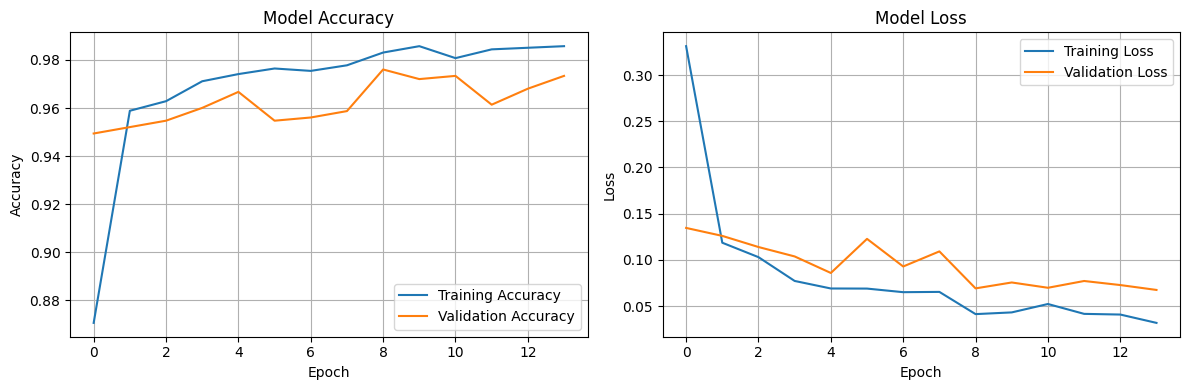

In [19]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
# Save the model to Google Drive
model_save_path = '/content/drive/MyDrive/rps_model.h5'
model.save(model_save_path)
print(f"\nModel saved to: {model_save_path}")


Model saved to: /content/drive/MyDrive/rps_model.h5


In [21]:
# Save class labels
import json
class_labels = {v: k for k, v in train_generator.class_indices.items()}
labels_save_path = '/content/drive/MyDrive/class_labels.json'
with open(labels_save_path, 'w') as f:
    json.dump(class_labels, f)
print(f"Class labels saved to: {labels_save_path}")

Class labels saved to: /content/drive/MyDrive/class_labels.json


In [22]:
# Print final accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\n{'='*50}")
print(f"TRAINING COMPLETE!")
print(f"{'='*50}")
print(f"Final Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
print(f"\nYou can now use the webcam script to test your model!")


TRAINING COMPLETE!
Final Training Accuracy: 98.57%
Final Validation Accuracy: 97.34%

You can now use the webcam script to test your model!


In [3]:
# -*- coding: utf-8 -*-
"""
Convert Keras model to TensorFlow Lite for stm32
This script creates a highly optimized model for microcontrollers
"""

import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from google.colab import drive
import json

# Mount Google Drive
drive.mount('/content/drive')

# Paths
MODEL_PATH = '/content/drive/MyDrive/rps_model.h5'
TFLITE_MODEL_PATH = '/content/drive/MyDrive/rps_model.tflite'
TFLITE_QUANT_MODEL_PATH = '/content/drive/MyDrive/rps_model_quantized.tflite'
C_ARRAY_PATH = '/content/drive/MyDrive/model_data.h'
DATA_DIR = '/content/drive/MyDrive/rps-cv-images'

print("="*60)
print("TensorFlow Lite Model Converter for stm32")
print("="*60)

# Load the trained model
print("\n1. Loading Keras model...")
model = keras.models.load_model(MODEL_PATH)
print(f"✓ Model loaded: {MODEL_PATH}")
model.summary()

# Create representative dataset for quantization
print("\n2. Creating representative dataset for quantization...")
def representative_dataset():
    dataset = keras.utils.image_dataset_from_directory(
        DATA_DIR,
        image_size=(224, 224),
        batch_size=1,
        shuffle=True
    )
    for i, (images, _) in enumerate(dataset.take(100)):
        images = tf.cast(images, tf.float32) / 255.0
        yield [images]

# Convert to TensorFlow Lite (Float32)
print("\n3. Converting to TensorFlow Lite (Float32)...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open(TFLITE_MODEL_PATH, 'wb') as f:
    f.write(tflite_model)
float_size = len(tflite_model) / 1024
print(f"✓ Float32 model saved: {TFLITE_MODEL_PATH}")
print(f"  Size: {float_size:.2f} KB")

# Convert with INT8 quantization (for stm32)
print("\n4. Converting to TensorFlow Lite (INT8 Quantized)...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()
with open(TFLITE_QUANT_MODEL_PATH, 'wb') as f:
    f.write(tflite_quant_model)
quant_size = len(tflite_quant_model) / 1024
print(f"✓ Quantized model saved: {TFLITE_QUANT_MODEL_PATH}")
print(f"  Size: {quant_size:.2f} KB")
print(f"  Compression ratio: {float_size/quant_size:.2f}x smaller")

# Test the quantized model accuracy
print("\n5. Testing quantized model accuracy...")
test_dataset = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

# Test float model
print("  Testing Float32 model...")
interpreter_float = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter_float.allocate_tensors()
input_details_float = interpreter_float.get_input_details()
output_details_float = interpreter_float.get_output_details()

correct_float = 0
total = 0
for images, labels in test_dataset:
    for i in range(len(images)):
        img = tf.cast(images[i:i+1], tf.float32) / 255.0
        interpreter_float.set_tensor(input_details_float[0]['index'], img)
        interpreter_float.invoke()
        output = interpreter_float.get_tensor(output_details_float[0]['index'])
        pred = np.argmax(output[0])
        if pred == labels[i].numpy():
            correct_float += 1
        total += 1
float_accuracy = (correct_float / total) * 100
print(f"    Float32 Accuracy: {float_accuracy:.2f}%")

# Test quantized model
print("  Testing INT8 Quantized model...")
interpreter_quant = tf.lite.Interpreter(model_path=TFLITE_QUANT_MODEL_PATH)
interpreter_quant.allocate_tensors()
input_details_quant = interpreter_quant.get_input_details()
output_details_quant = interpreter_quant.get_output_details()

correct_quant = 0
total = 0
for images, labels in test_dataset:
    for i in range(len(images)):
        img = tf.cast(images[i:i+1], tf.float32) / 255.0
        input_scale = input_details_quant[0]['quantization'][0]
        input_zero_point = input_details_quant[0]['quantization'][1]
        img_quantized = img / input_scale + input_zero_point
        img_quantized = np.clip(img_quantized, -128, 127).astype(np.int8)
        interpreter_quant.set_tensor(input_details_quant[0]['index'], img_quantized)
        interpreter_quant.invoke()
        output = interpreter_quant.get_tensor(output_details_quant[0]['index'])
        output_scale = output_details_quant[0]['quantization'][0]
        output_zero_point = output_details_quant[0]['quantization'][1]
        output_dequantized = (output.astype(np.float32) - output_zero_point) * output_scale
        pred = np.argmax(output_dequantized[0])
        if pred == labels[i].numpy():
            correct_quant += 1
        total += 1
quant_accuracy = (correct_quant / total) * 100
print(f"    INT8 Quantized Accuracy: {quant_accuracy:.2f}%")
print(f"    Accuracy loss: {float_accuracy - quant_accuracy:.2f}%")

# Convert to C array for stm32
print("\n6. Converting to C header file for stm32...")
def convert_to_c_array(model_data, var_name):
    c_array = f"// Auto-generated model data\n"
    c_array += f"// Model size: {len(model_data)} bytes\n\n"
    c_array += f"const unsigned int {var_name}_len = {len(model_data)};\n"
    c_array += f"alignas(8) const unsigned char {var_name}[] = {{\n"
    hex_array = [f"0x{b:02x}" for b in model_data]
    for i in range(0, len(hex_array), 12):
        row = ", ".join(hex_array[i:i+12])
        c_array += f"  {row},\n"
    c_array += "};\n"
    return c_array

c_code = convert_to_c_array(tflite_quant_model, "rps_model_data")
with open(C_ARRAY_PATH, 'w') as f:
    f.write(c_code)
print(f"✓ C header file saved: {C_ARRAY_PATH}")

# Save model info
model_info = {
    'input_shape': list(model.input_shape),
    'output_shape': list(model.output_shape),
    'model_size_kb': quant_size,
    'float_accuracy': float_accuracy,
    'quantized_accuracy': quant_accuracy,
    'input_scale': float(input_details_quant[0]['quantization'][0]),
    'input_zero_point': int(input_details_quant[0]['quantization'][1]),
    'output_scale': float(output_details_quant[0]['quantization'][0]),
    'output_zero_point': int(output_details_quant[0]['quantization'][1])
}

with open('/content/drive/MyDrive/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print("\n✓ Model info saved to model_info.json")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow Lite Model Converter for stm32

1. Loading Keras model...


✓ Model loaded: /content/drive/MyDrive/rps_model.h5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,341 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)


2. Creating representative dataset for quantization...

3. Converting to TensorFlow Lite (Float32)...
Saved artifact at '/tmp/tmpb_z2r6w8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138543835272336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543835273488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543835273296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543701735568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543835273104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543835272720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543835273680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543835273872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543835272912: TensorSpec(shape=(), dtype=tf.res

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Found 3765 files belonging to 3 classes.
✓ Quantized model saved: /content/drive/MyDrive/rps_model_quantized.tflite
  Size: 2809.52 KB
  Compression ratio: 0.93x smaller

5. Testing quantized model accuracy...
Found 3765 files belonging to 3 classes.
  Testing Float32 model...


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


    Float32 Accuracy: 98.91%
  Testing INT8 Quantized model...
    INT8 Quantized Accuracy: 99.04%
    Accuracy loss: -0.13%

6. Converting to C header file for stm32...
✓ C header file saved: /content/drive/MyDrive/model_data.h

✓ Model info saved to model_info.json
